In [ ]:
!pip install pytorch_model_summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/dfw
!ls

/content/drive/My Drive/Colab Notebooks/dfw
build  dfw.egg-info  frankwolfe_dnn.ipynb  README.md
data   dist	     LICENSE		   requirements.txt
dfw    experiments   plot_cifar.png	   setup.py


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from pytorch_model_summary import summary

In [ ]:
import torchvision
import torchvision.datasets as datasets

#### Goal: Composite optimizers -> Frank Wolfe / SGD / ADAM 

### Part 1: DNN Mnist Frank Wolfe grid-search

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [ ]:
mnist_train = mnist_trainset.data
mnist_test = mnist_testset.data

mnist_trainlabel = mnist_trainset.targets
mnist_testlabel = mnist_testset.targets

In [ ]:
print(mnist_train.shape)
print(mnist_test.shape)
print(mnist_trainlabel.shape)
print(mnist_testlabel.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000])
torch.Size([10000])


In [ ]:
from dfw import DFW
from dfw.losses import MultiClassHingeLoss

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, 10) 


    def forward(self, x):
        x = x.view(-1,784) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
print(summary(MLP(), torch.zeros((1, 1, 28, 28)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1            [1, 784]         100,480         100,480
          Linear-2            [1, 128]           8,256           8,256
          Linear-3             [1, 64]             650             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
-----------------------------------------------------------------------


In [ ]:
def accuracy(y_pred,y_ground):
    return (torch.sum(torch.argmax(y_pred,axis=1) == y_ground) / y_ground.size(0)).item()

In [ ]:
def train(model, train_input, train_target, test_input, test_target,
                mini_batch_size=50, nb_epochs = 100,eta = 1e-3, verbose=1):
    
    svm = MultiClassHingeLoss()
    optimizer = DFW(model.parameters(), eta=eta)
    
    history = {}
    history['loss'] = []
    history['loss_val'] = []
    history['acc'] = []
    history['acc_val'] = []
    
    for e in range(nb_epochs):
        total_loss = 0

        for b in range(0, train_input.size(0), mini_batch_size):
            try: 
                output = model(train_input.narrow(0, b , mini_batch_size))
            except:
                continue
            loss = svm(output, train_target.narrow(0, b, mini_batch_size))
            total_loss = total_loss + loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(lambda: float(loss))
        
        if e%10==0:
            # yea probably need to check if there is smarter way to evaluate 
            output_train = model(train_input.float())
            output_val = model(test_input.float())
            
            accuracy_train = accuracy(output_train, train_target)
            accuracy_val = accuracy(output_val, test_target)
            loss_train = svm(output_train, train_target).item()
            loss_val = svm(output_val, test_target).item()
            
            history['loss'].append(loss_train)
            history['loss_val'].append(loss_val)
            history['acc'].append(accuracy_train)
            history['acc_val'].append(accuracy_val)
            
            if verbose : 
#                print(e, total_loss)
                print('epoch {}: acc -> {} | acc_val -> {}'.format(e, accuracy_train,accuracy_val))
        
    return history    

In [ ]:
torch.manual_seed(123456789) # seeding for weight initialization and train

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

histories = []

bss = [50,64,128]
lrs = [1e-2,1e-3, 5e-3, 1e-4]

mesh = np.meshgrid(bss,lrs)

for bs,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('batch-size: {} | learning-rate: {}'.format(bs,lr))
    # reset weights
    mlp = MLP().to(device)

    history = train(mlp, mnist_train.float(), mnist_trainlabel,
                mnist_test.float(), mnist_testlabel,
                mini_batch_size=bs,nb_epochs = 100,eta=lr,verbose=False)
    
    histories.append(history)

batch-size: 50 | learning-rate: 0.01
batch-size: 64 | learning-rate: 0.01
batch-size: 128 | learning-rate: 0.01
batch-size: 50 | learning-rate: 0.001
batch-size: 64 | learning-rate: 0.001
batch-size: 128 | learning-rate: 0.001
batch-size: 50 | learning-rate: 0.005
batch-size: 64 | learning-rate: 0.005
batch-size: 128 | learning-rate: 0.005
batch-size: 50 | learning-rate: 0.0001
batch-size: 64 | learning-rate: 0.0001
batch-size: 128 | learning-rate: 0.0001


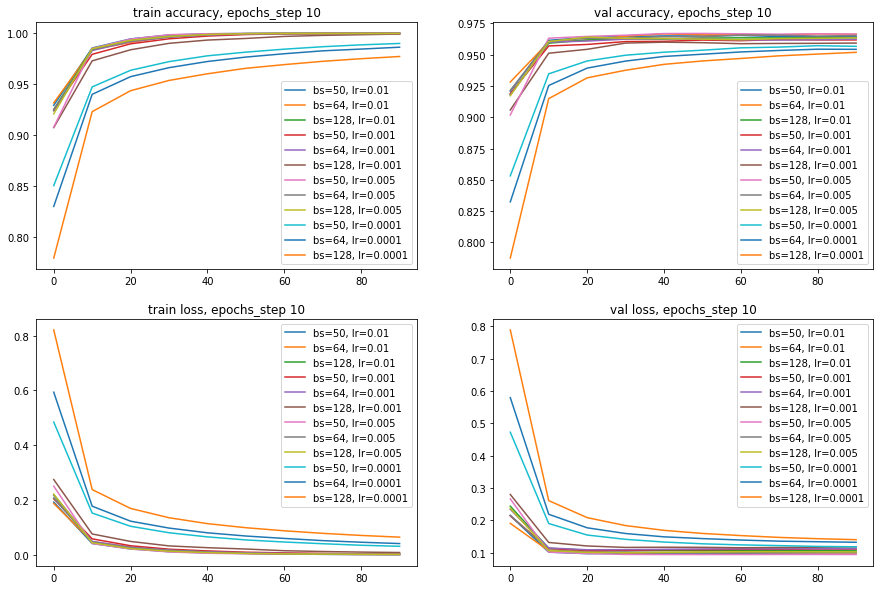

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(15,10))
for j,(bs,lr) in enumerate(zip(mesh[0].ravel(),mesh[1].ravel())):
  ax[0,0].plot([10*i for i in range(10)],histories[j]['acc'],label='bs={}, lr={}'.format(bs,lr))
  ax[0,1].plot([10*i for i in range(10)],histories[j]['acc_val'],label='bs={}, lr={}'.format(bs,lr))

  ax[1,0].plot([10*i for i in range(10)],histories[j]['loss'],label='bs={}, lr={}'.format(bs,lr))
  ax[1,1].plot([10*i for i in range(10)],histories[j]['loss_val'],label='bs={}, lr={}'.format(bs,lr))

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

ax[0,0].set_title('train accuracy, epochs_step 10')
ax[0,1].set_title('val accuracy, epochs_step 10')
ax[1,0].set_title('train loss, epochs_step 10')
ax[1,1].set_title('val loss, epochs_step 10')
plt.show()

### Part 2: CNN Mnist Frank Wolfe grid-search
On Cifar 10

In [ ]:
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 20

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = nn.Conv2d(3, 32, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(32, 64, 5)
        # self.fc1 = nn.Linear(64 * 5 * 5, 312)
        # self.fc2 = nn.Linear(312, 84)

        self.base = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 5 * 5, 312),
            nn.ReLU(),
            nn.Linear(312, 84),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)

        x = self.base(x)
        x = self.fc3(x)
        return x

<b> Baseline on general architecture with one optimizer one whole train. </b>

In [ ]:
cnn = CNN()
print(summary(CNN(), torch.zeros((1, 3, 32, 32)), show_input=True))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]           2,432           2,432
       MaxPool2d-2     [1, 32, 28, 28]               0               0
          Conv2d-3     [1, 32, 14, 14]          51,264          51,264
       MaxPool2d-4     [1, 64, 10, 10]               0               0
         Flatten-5       [1, 64, 5, 5]               0               0
          Linear-6           [1, 1600]         499,512         499,512
            ReLU-7            [1, 312]               0               0
          Linear-8            [1, 312]          26,292          26,292
            ReLU-9             [1, 84]               0               0
         Linear-10             [1, 84]             850             850
Total params: 580,350
Trainable params: 580,350
Non-trainable params: 0
-----------------------------------------------------------------------


In [ ]:
acc_val = []
loss_train = []
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        rep = 1000
        if i % rep == 999:    # print every 2000 mini-batches
            loss_train.append(running_loss/rep)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / rep))
            running_loss = 0.0
            correct = 0
            total = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    # calculate outputs by running images through the network
                    outputs = cnn(images)
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * correct / total))
            acc_val.append(correct / total)
            

print('Finished Training')

[1,  1000] loss: 2.219
Accuracy of the network on the 10000 test images: 27 %
[1,  2000] loss: 1.820
Accuracy of the network on the 10000 test images: 38 %
[2,  1000] loss: 1.549
Accuracy of the network on the 10000 test images: 43 %
[2,  2000] loss: 1.462
Accuracy of the network on the 10000 test images: 50 %
[3,  1000] loss: 1.337
Accuracy of the network on the 10000 test images: 53 %
[3,  2000] loss: 1.265
Accuracy of the network on the 10000 test images: 54 %
[4,  1000] loss: 1.169
Accuracy of the network on the 10000 test images: 58 %
[4,  2000] loss: 1.107
Accuracy of the network on the 10000 test images: 59 %
[5,  1000] loss: 1.028
Accuracy of the network on the 10000 test images: 62 %
[5,  2000] loss: 0.988
Accuracy of the network on the 10000 test images: 64 %
[6,  1000] loss: 0.915
Accuracy of the network on the 10000 test images: 63 %
[6,  2000] loss: 0.898
Accuracy of the network on the 10000 test images: 65 %
[7,  1000] loss: 0.830
Accuracy of the network on the 10000 test

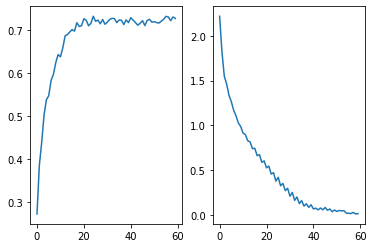

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].plot(range(len(acc_val)),acc_val)
ax[1].plot(range(len(loss_train)),loss_train)

In [ ]:
cnn = CNN()
print(summary(CNN(), torch.zeros((1, 3, 32, 32)), show_input=True))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]           2,432           2,432
       MaxPool2d-2     [1, 32, 28, 28]               0               0
          Conv2d-3     [1, 32, 14, 14]          51,264          51,264
          Linear-4           [1, 1600]         499,512         499,512
          Linear-5            [1, 312]          26,292          26,292
          Linear-6             [1, 84]             850             850
Total params: 580,350
Trainable params: 580,350
Non-trainable params: 0
-----------------------------------------------------------------------


In [ ]:
acc_val = []
loss_train = []
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        rep = 1000
        if i % rep == 999:    # print every 2000 mini-batches
            loss_train.append(running_loss/rep)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / rep))
            running_loss = 0.0
            correct = 0
            total = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    # calculate outputs by running images through the network
                    outputs = cnn(images)
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * correct / total))
            acc_val.append(correct / total)

print('Finished Training')

[1,  1000] loss: 1.637
Accuracy of the network on the 10000 test images: 49 %
[1,  2000] loss: 1.313
Accuracy of the network on the 10000 test images: 55 %
[2,  1000] loss: 1.077
Accuracy of the network on the 10000 test images: 61 %
[2,  2000] loss: 1.022
Accuracy of the network on the 10000 test images: 64 %
[3,  1000] loss: 0.868
Accuracy of the network on the 10000 test images: 65 %
[3,  2000] loss: 0.858
Accuracy of the network on the 10000 test images: 67 %
[4,  1000] loss: 0.740
Accuracy of the network on the 10000 test images: 67 %
[4,  2000] loss: 0.738
Accuracy of the network on the 10000 test images: 70 %
[5,  1000] loss: 0.632
Accuracy of the network on the 10000 test images: 69 %
[5,  2000] loss: 0.658
Accuracy of the network on the 10000 test images: 70 %
[6,  1000] loss: 0.549
Accuracy of the network on the 10000 test images: 70 %
[6,  2000] loss: 0.574
Accuracy of the network on the 10000 test images: 71 %
[7,  1000] loss: 0.477
Accuracy of the network on the 10000 test

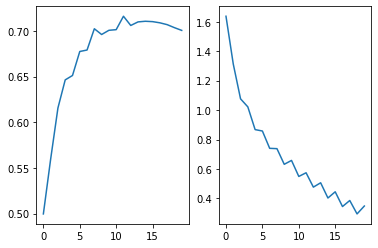

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].plot(range(len(acc_val)),acc_val)
ax[1].plot(range(len(loss_train)),loss_train)

In [ ]:
from dfw import DFW
from dfw.losses import MultiClassHingeLoss

In [ ]:
cnn = CNN()
print(summary(CNN(), torch.zeros((1, 3, 32, 32)), show_input=True))

criterion = MultiClassHingeLoss()
optimizer = DFW(cnn.parameters(), eta=0.001)

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]           2,432           2,432
       MaxPool2d-2     [1, 32, 28, 28]               0               0
          Conv2d-3     [1, 32, 14, 14]          51,264          51,264
          Linear-4           [1, 1600]         499,512         499,512
          Linear-5            [1, 312]          26,292          26,292
          Linear-6             [1, 84]             850             850
Total params: 580,350
Trainable params: 580,350
Non-trainable params: 0
-----------------------------------------------------------------------


In [ ]:
acc_val = []
loss_train = []
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step(lambda: float(loss))

        # print statistics
        running_loss += loss.item()
        rep = 1000
        if i % rep == 999:    # print every 2000 mini-batches
            loss_train.append(running_loss/rep)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / rep))
            running_loss = 0.0
            correct = 0
            total = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    # calculate outputs by running images through the network
                    outputs = cnn(images)
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * correct / total))
            acc_val.append(correct / total)
            

print('Finished Training')

[1,  1000] loss: 1.018
Accuracy of the network on the 10000 test images: 16 %
[1,  2000] loss: 1.005
Accuracy of the network on the 10000 test images: 20 %
[2,  1000] loss: 1.003
Accuracy of the network on the 10000 test images: 22 %
[2,  2000] loss: 1.003
Accuracy of the network on the 10000 test images: 23 %
[3,  1000] loss: 1.002
Accuracy of the network on the 10000 test images: 24 %
[3,  2000] loss: 1.002
Accuracy of the network on the 10000 test images: 25 %
[4,  1000] loss: 1.002
Accuracy of the network on the 10000 test images: 26 %
[4,  2000] loss: 1.002
Accuracy of the network on the 10000 test images: 27 %
[5,  1000] loss: 1.002
Accuracy of the network on the 10000 test images: 28 %
[5,  2000] loss: 1.002
Accuracy of the network on the 10000 test images: 29 %
[6,  1000] loss: 1.001
Accuracy of the network on the 10000 test images: 30 %
[6,  2000] loss: 1.001
Accuracy of the network on the 10000 test images: 29 %
[7,  1000] loss: 1.001
Accuracy of the network on the 10000 test

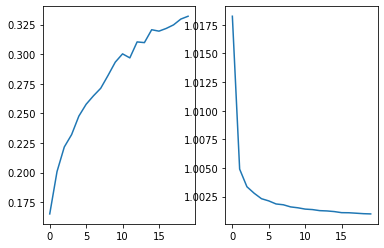

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].plot(range(len(acc_val)),acc_val)
ax[1].plot(range(len(loss_train)),loss_train)

### Optim Combinations: Permutation hidden layer optim1 and output layer optim2.

<b> Combine Franke wolfe output and adam hidden </b>

In [ ]:
cnn = CNN()
print(summary(CNN(), torch.zeros((1, 3, 32, 32)), show_input=True))


criterion = MultiClassHingeLoss()
optimizer = DFW(cnn.fc3.parameters(), eta=0.01)
optimizer_hidden = optim.Adam(cnn.base.parameters(), lr=0.001)

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]           2,432           2,432
       MaxPool2d-2     [1, 32, 28, 28]               0               0
          Conv2d-3     [1, 32, 14, 14]          51,264          51,264
       MaxPool2d-4     [1, 64, 10, 10]               0               0
         Flatten-5       [1, 64, 5, 5]               0               0
          Linear-6           [1, 1600]         499,512         499,512
            ReLU-7            [1, 312]               0               0
          Linear-8            [1, 312]          26,292          26,292
            ReLU-9             [1, 84]               0               0
         Linear-10             [1, 84]             850             850
Total params: 580,350
Trainable params: 580,350
Non-trainable params: 0
-----------------------------------------------------------------------


In [ ]:
acc_val = []
loss_train = []
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step(lambda: float(loss))
        optimizer_hidden.step()

        # print statistics
        running_loss += loss.item()
        rep = 1000
        if i % rep == 999:    # print every 2000 mini-batches
            loss_train.append(running_loss/rep)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / rep))
            running_loss = 0.0
            correct = 0
            total = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    # calculate outputs by running images through the network
                    outputs = cnn(images)
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * correct / total))
            acc_val.append(correct / total)
            

print('Finished Training')

[1,  1000] loss: 1.041
Accuracy of the network on the 10000 test images: 10 %
[1,  2000] loss: 1.004
Accuracy of the network on the 10000 test images: 10 %
[2,  1000] loss: 887.505
Accuracy of the network on the 10000 test images: 10 %
[2,  2000] loss: 1.004
Accuracy of the network on the 10000 test images: 10 %
[3,  1000] loss: 1.004
Accuracy of the network on the 10000 test images: 10 %
[3,  2000] loss: 1.004
Accuracy of the network on the 10000 test images: 10 %
[4,  1000] loss: 1.004
Accuracy of the network on the 10000 test images: 10 %
[4,  2000] loss: 1.004
Accuracy of the network on the 10000 test images: 10 %
[5,  1000] loss: 1.004
Accuracy of the network on the 10000 test images: 10 %
[5,  2000] loss: 1.004
Accuracy of the network on the 10000 test images: 10 %
[6,  1000] loss: 1.004
Accuracy of the network on the 10000 test images: 10 %
[6,  2000] loss: 1.004
Accuracy of the network on the 10000 test images: 10 %
[7,  1000] loss: 1.004
Accuracy of the network on the 10000 te

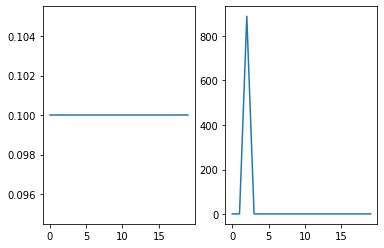

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].plot(range(len(acc_val)),acc_val)
ax[1].plot(range(len(loss_train)),loss_train)

<b> Combine Frank Wolfe output and SGD hidden </b>

In [ ]:
cnn = CNN()
print(summary(CNN(), torch.zeros((1, 3, 32, 32)), show_input=True))


criterion = MultiClassHingeLoss()
optimizer = DFW(cnn.fc3.parameters(), eta=0.01)
optimizer_hidden = optim.SGD(cnn.base.parameters(), lr=0.001)

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]           2,432           2,432
       MaxPool2d-2     [1, 32, 28, 28]               0               0
          Conv2d-3     [1, 32, 14, 14]          51,264          51,264
       MaxPool2d-4     [1, 64, 10, 10]               0               0
         Flatten-5       [1, 64, 5, 5]               0               0
          Linear-6           [1, 1600]         499,512         499,512
            ReLU-7            [1, 312]               0               0
          Linear-8            [1, 312]          26,292          26,292
            ReLU-9             [1, 84]               0               0
         Linear-10             [1, 84]             850             850
Total params: 580,350
Trainable params: 580,350
Non-trainable params: 0
-----------------------------------------------------------------------


In [ ]:
acc_val = []
loss_train = []
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step(lambda: float(loss))
        optimizer_hidden.step()

        # print statistics
        running_loss += loss.item()
        rep = 1000
        if i % rep == 999:    # print every 2000 mini-batches
            loss_train.append(running_loss/rep)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / rep))
            running_loss = 0.0
            correct = 0
            total = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    # calculate outputs by running images through the network
                    outputs = cnn(images)
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * correct / total))
            acc_val.append(correct / total)
            

print('Finished Training')

[1,  1000] loss: 1.006
Accuracy of the network on the 10000 test images: 37 %
[1,  2000] loss: 1.006
Accuracy of the network on the 10000 test images: 10 %
[2,  1000] loss: 1.646
Accuracy of the network on the 10000 test images: 10 %
[2,  2000] loss: nan
Accuracy of the network on the 10000 test images: 10 %
[3,  1000] loss: nan
Accuracy of the network on the 10000 test images: 10 %
[3,  2000] loss: nan
Accuracy of the network on the 10000 test images: 10 %
[4,  1000] loss: nan
Accuracy of the network on the 10000 test images: 10 %
[4,  2000] loss: nan
Accuracy of the network on the 10000 test images: 10 %
[5,  1000] loss: nan
Accuracy of the network on the 10000 test images: 10 %
[5,  2000] loss: nan
Accuracy of the network on the 10000 test images: 10 %
[6,  1000] loss: nan
Accuracy of the network on the 10000 test images: 10 %
[6,  2000] loss: nan
Accuracy of the network on the 10000 test images: 10 %
[7,  1000] loss: nan
Accuracy of the network on the 10000 test images: 10 %
[7,  2

<b> Combine Adam output and Frank Wolfe hidden </b>

In [ ]:
cnn = CNN()
print(summary(CNN(), torch.zeros((1, 3, 32, 32)), show_input=True))


criterion = nn.CrossEntropyLoss()
criterion2 = MultiClassHingeLoss()
optimizer = optim.Adam(cnn.fc3.parameters(), lr=0.001) 
optimizer_hidden = DFW(cnn.base.parameters(), eta=0.01)

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]           2,432           2,432
       MaxPool2d-2     [1, 32, 28, 28]               0               0
          Conv2d-3     [1, 32, 14, 14]          51,264          51,264
       MaxPool2d-4     [1, 64, 10, 10]               0               0
         Flatten-5       [1, 64, 5, 5]               0               0
          Linear-6           [1, 1600]         499,512         499,512
            ReLU-7            [1, 312]               0               0
          Linear-8            [1, 312]          26,292          26,292
            ReLU-9             [1, 84]               0               0
         Linear-10             [1, 84]             850             850
Total params: 580,350
Trainable params: 580,350
Non-trainable params: 0
-----------------------------------------------------------------------


In [ ]:
acc_val = []
loss_train = []
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss2 = criterion2(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer_hidden.step(lambda: float(loss2))

        # print statistics
        running_loss += loss.item()
        rep = 1000
        if i % rep == 999:    # print every 2000 mini-batches
            loss_train.append(running_loss/rep)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / rep))
            running_loss = 0.0
            correct = 0
            total = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    # calculate outputs by running images through the network
                    outputs = cnn(images)
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * correct / total))
            acc_val.append(correct / total)
            

print('Finished Training')

[1,  1000] loss: 1.828
Accuracy of the network on the 10000 test images: 42 %
[1,  2000] loss: 1.545
Accuracy of the network on the 10000 test images: 47 %
[2,  1000] loss: 1.389
Accuracy of the network on the 10000 test images: 51 %
[2,  2000] loss: 1.330
Accuracy of the network on the 10000 test images: 53 %
[3,  1000] loss: 1.237
Accuracy of the network on the 10000 test images: 54 %
[3,  2000] loss: 1.215
Accuracy of the network on the 10000 test images: 57 %
[4,  1000] loss: 1.156
Accuracy of the network on the 10000 test images: 58 %
[4,  2000] loss: 1.160
Accuracy of the network on the 10000 test images: 57 %
[5,  1000] loss: 1.105
Accuracy of the network on the 10000 test images: 60 %
[5,  2000] loss: 1.095
Accuracy of the network on the 10000 test images: 60 %
[6,  1000] loss: 1.059
Accuracy of the network on the 10000 test images: 60 %
[6,  2000] loss: 1.041
Accuracy of the network on the 10000 test images: 62 %
[7,  1000] loss: 1.041
Accuracy of the network on the 10000 test

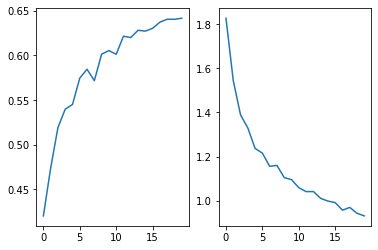

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].plot(range(len(acc_val)),acc_val)
ax[1].plot(range(len(loss_train)),loss_train)

In [ ]:
cnn = CNN()
print(summary(CNN(), torch.zeros((1, 3, 32, 32)), show_input=True))


criterion = nn.CrossEntropyLoss()
criterion2 = MultiClassHingeLoss()
optimizer = optim.SGD(cnn.fc3.parameters(), lr=0.001) 
optimizer_hidden = DFW(cnn.base.parameters(), eta=0.01)

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]           2,432           2,432
       MaxPool2d-2     [1, 32, 28, 28]               0               0
          Conv2d-3     [1, 32, 14, 14]          51,264          51,264
       MaxPool2d-4     [1, 64, 10, 10]               0               0
         Flatten-5       [1, 64, 5, 5]               0               0
          Linear-6           [1, 1600]         499,512         499,512
            ReLU-7            [1, 312]               0               0
          Linear-8            [1, 312]          26,292          26,292
            ReLU-9             [1, 84]               0               0
         Linear-10             [1, 84]             850             850
Total params: 580,350
Trainable params: 580,350
Non-trainable params: 0
-----------------------------------------------------------------------


In [ ]:
acc_val = []
loss_train = []
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss2 = criterion2(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer_hidden.step(lambda: float(loss2))

        # print statistics
        running_loss += loss.item()
        rep = 1000
        if i % rep == 999:    # print every 2000 mini-batches
            loss_train.append(running_loss/rep)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / rep))
            running_loss = 0.0
            correct = 0
            total = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    # calculate outputs by running images through the network
                    outputs = cnn(images)
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * correct / total))
            acc_val.append(correct / total)
            

print('Finished Training')

[1,  1000] loss: 1.798
Accuracy of the network on the 10000 test images: 42 %
[1,  2000] loss: 1.546
Accuracy of the network on the 10000 test images: 47 %
[2,  1000] loss: 1.334
Accuracy of the network on the 10000 test images: 54 %
[2,  2000] loss: 1.286
Accuracy of the network on the 10000 test images: 55 %
[3,  1000] loss: 1.193
Accuracy of the network on the 10000 test images: 56 %
[3,  2000] loss: 1.200
Accuracy of the network on the 10000 test images: 56 %
[4,  1000] loss: 1.139
Accuracy of the network on the 10000 test images: 58 %
[4,  2000] loss: 1.121
Accuracy of the network on the 10000 test images: 60 %
[5,  1000] loss: 1.104
Accuracy of the network on the 10000 test images: 60 %
[5,  2000] loss: 1.104
Accuracy of the network on the 10000 test images: 60 %
[6,  1000] loss: 1.036
Accuracy of the network on the 10000 test images: 62 %
[6,  2000] loss: 1.049
Accuracy of the network on the 10000 test images: 62 %
[7,  1000] loss: 1.031
Accuracy of the network on the 10000 test